# Script to do the extraction face information

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from collections import defaultdict

from deepface import DeepFace
from deepface.detectors import FaceDetector
from deepface.DeepFace import build_model
from deepface.commons.functions import load_image
from tensorflow import keras

from deepface.extendedmodels import Age, Gender, Race, Emotion

In [18]:
#detections_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_1_HQ.npy'
detections_path = '../../../../mnt/DATA/datasets/soccernet/germany_bundesliga/2014-2015/2015-05-02 - 16-30 Hoffenheim 1 - 1 Dortmund/face_detection_results_1_HQ.npy'
face_detections = np.load(detections_path, allow_pickle=True)
face_detections = face_detections[0]
face = face_detections['00104']['face_1']['facial_area']
face


[729, 191, 813, 301]

In [19]:
def area(face):
    a = abs(face[1] - face[3]) * abs(face[0] - face[2])
    return a
area(face)

9240

In [20]:
#image_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames/02032.jpg'
image_path = '../../../../mnt/DATA/datasets/soccernet/germany_bundesliga/2014-2015/2015-05-02 - 16-30 Hoffenheim 1 - 1 Dortmund/1_HQ/frames/00104.jpg'
frame = cv2.imread(image_path)
#cv2.rectangle(image, (face[3], face[0]), (face[1],face[2]), (0,0,255), 3) #3012 para face_locations
#cv2.rectangle(frame, (face[0], face[1]), (face[2],face[3]), (0,255,100), 3) 
#fig = plt.figure(figsize=(15,7.5)) 
#plt.imshow(frame)
#plt.show() 

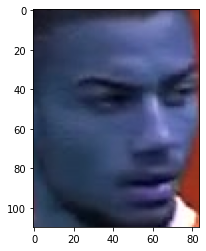

In [21]:
frame_face = frame[face[1]:face[3],face[0]:face[2],:]
plt.imshow(frame_face)
plt.show() 


## Model Code

In [7]:
# analyze output (emotions)
DeepFace.analyze(frame_face, actions = ['emotion'], enforce_detection=False)

{'emotion': {'angry': 49.38460886478424,
  'disgust': 4.39281694786936e-11,
  'fear': 0.4364923108369112,
  'happy': 1.8320197581189746e-07,
  'sad': 4.535599797964096,
  'surprise': 1.6740588915098442e-07,
  'neutral': 45.6432968378067},
 'dominant_emotion': 'angry',
 'region': {'x': 0, 'y': 0, 'w': 110, 'h': 84}}

In [8]:
from tensorflow.keras.preprocessing import image

def preprocess_face(img, target_size=(224, 224), grayscale = False, align = True):

    #img might be path, base64 or numpy array. Convert it to numpy whatever it is.
    img = load_image(img)
    base_img = img.copy()

    # img, region = detect_face(img = img, detector_backend = detector_backend, grayscale = grayscale, enforce_detection = enforce_detection, align = align)

    #--------------------------

    if img.shape[0] == 0 or img.shape[1] == 0:
        if enforce_detection == True:
            raise ValueError("Detected face shape is ", img.shape,". Consider to set enforce_detection argument to False.")
        else: #restore base image
            img = base_img.copy()

    #--------------------------

    #post-processing
    if grayscale == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #---------------------------------------------------
    #resize image to expected shape

    # img = cv2.resize(img, target_size) #resize causes transformation on base image, adding black pixels to resize will not deform the base image

    if img.shape[0] > 0 and img.shape[1] > 0:
        factor_0 = target_size[0] / img.shape[0]
        factor_1 = target_size[1] / img.shape[1]
        factor = min(factor_0, factor_1)

        dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
        img = cv2.resize(img, dsize)

        # Then pad the other side to the target size by adding black pixels
        diff_0 = target_size[0] - img.shape[0]
        diff_1 = target_size[1] - img.shape[1]
        if grayscale == False:
            # Put the base image in the middle of the padded image
            img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
        else:
            img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')

    #------------------------------------------

    #double check: if target image is not still the same size with target.
    if img.shape[0:2] != target_size:
        img = cv2.resize(img, target_size)

    #---------------------------------------------------

    #normalizing the image pixels

    img_pixels = image.img_to_array(img) #what this line doing? must?
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255 #normalize input in [0, 1]

    #---------------------------------------------------


    return img_pixels

In [9]:
# using our model directly using the library funcionts (layer 13 is the same than analyze output), 8 is the flatten vect
# we have to go deeper
model = build_model('Emotion')
img = preprocess_face(img = frame_face, target_size = (48, 48), grayscale = True)
extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
features = extractor(img)
vector = features[13].numpy()[0] # paraleliza!!
vector

array([4.9384528e-01, 4.3927928e-13, 4.3649054e-03, 1.8320238e-09,
       4.5356024e-02, 1.6740463e-09, 4.5643371e-01], dtype=float32)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         1

## Generator Code

In [11]:
from multiprocessing import Pool
from pathlib import Path

In [13]:
# we will only read the images that have a face
faces_frames = [k for k, v in face_detections.items() if len(v) > 0]
faces_frames

['00104',
 '00105',
 '00106',
 '00107',
 '00108',
 '00109',
 '00110',
 '00111',
 '00112',
 '00113',
 '00114',
 '00115',
 '00116',
 '00117',
 '00118',
 '00119',
 '00120',
 '00121',
 '00122',
 '00123',
 '00124',
 '00125',
 '00126',
 '00127',
 '00128',
 '00129',
 '00130',
 '00131',
 '00132',
 '00133',
 '00134',
 '00135',
 '00136',
 '00137',
 '00138',
 '00139',
 '00140',
 '00216',
 '00217',
 '00218',
 '00219',
 '00220',
 '00221',
 '00222',
 '00223',
 '00224',
 '00225',
 '00227',
 '00228',
 '00237',
 '00238',
 '00239',
 '00240',
 '00241',
 '00242',
 '00243',
 '00244',
 '00263',
 '00264',
 '00265',
 '00266',
 '00267',
 '00268',
 '00269',
 '00270',
 '00271',
 '00274',
 '00275',
 '00277',
 '00278',
 '00279',
 '00280',
 '00281',
 '00282',
 '00283',
 '00284',
 '00285',
 '00286',
 '00287',
 '00288',
 '00289',
 '00290',
 '00291',
 '00292',
 '00293',
 '00294',
 '00295',
 '00296',
 '00339',
 '00340',
 '00341',
 '00342',
 '00343',
 '00344',
 '00345',
 '00346',
 '00347',
 '00348',
 '00349',
 '00350',


In [13]:
def load_image1(frame_idx, frame_path):
    # frame_idx, frame_path = arg
    img = cv2.imread(frame_path)
    return frame_idx, img

class FaceFeeder:

    def __init__(self, directory, valid_frames, batch_size, num_processes=10):

        self.directory = Path(directory)
        self.valid_frames = valid_frames
        self.batch_size = batch_size
        self.num_processes = num_processes

        batch_list = []
        for i in range(0, len(self.valid_frames), self.batch_size):
            batch_list.append(self.valid_frames[i:i + self.batch_size])
        self.batch_list = batch_list

    def __len__(self):
        return int(np.ceil(len(self.valid_frames) / self.batch_size))

    def __getitem__(self, index):

        batch = np.zeros([self.batch_size, 1024, 1820, 3])  # FIXME: revisar size mas videos

        frame_paths, frame_indices = [], []
        for idx, num in enumerate(self.batch_list[index]):
            # frame_paths.append(str(self.directory.joinpath(str(f'{num:05}') + '.jpg')))
            #TODO: keep in mind now num is a string
            frame_paths.append(str(self.directory.joinpath(str(f'{num}') + '.jpg')))
            frame_indices.append(idx)
        
        batch = np.zeros([self.batch_size, 1080, 1920, 3])
        
        for path, index in zip(frame_paths, frame_indices):
            im_id, im = load_image1(index, str(path))
            batch[im_id,:,:,:] = im        

        return batch.astype(np.uint8)

In [14]:
frames_dir = Path('../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/1_HQ/frames')
l = FaceFeeder(frames_dir, faces_frames, 2)
n_batch = 100
b = l.__getitem__(n_batch)
bl = l.batch_list[n_batch]
# print(bl[0])
# face_detections[bl[0]]
b.shape


(2, 1080, 1920, 3)

In [14]:
# given a frame and a list of faces, get a preprocessed batch of faces
def frame_to_faces(image, faces):
    faces_batch = np.zeros([len(faces),48,48,1])
    
    for f in range(0,len(faces)):
        area = faces[f'face_{f+1}']['facial_area']
        face = image[area[1]:area[3], area[0]:area[2],:]
        face = preprocess_face(img = face, target_size = (48, 48), grayscale = True)
        faces_batch[f-1,:,:,:] = face
        
    return faces_batch

faces_batch = frame_to_faces(b[0], face_detections[bl[0]])
faces_batch.shape

(14, 48, 48, 1)

In [15]:
def num_batch_faces(batch_list, faces):
    count = 0
    for frame in batch_list:
        count += len(faces[frame])
    return count
        
num_batch_faces(bl, face_detections)

29

In [16]:
# given a frame batch --> faces batch of all frames
def frame_batch_to_faces(frame_batch, faces, batch_list):

    num_faces = num_batch_faces(batch_list, faces)
    big_batch = np.zeros([num_faces, 48, 48, 1])
    frame_nums = np.zeros(num_faces, dtype=int)
    first_len = 0
    
    for i in range(len(frame_batch)):     
        faces_frame = frame_to_faces(frame_batch[i], faces[batch_list[i]])
        big_batch[first_len:first_len+len(faces_frame),:,:,:] = faces_frame[:,:,:,:]    
        frame_nums[first_len:first_len+len(faces_frame)] = i #batch_list[i]
        first_len = len(faces_frame)

    return big_batch, frame_nums
    
faces_total_batch, frame_nums = frame_batch_to_faces(b, face_detections, bl)

print(faces_total_batch.shape)
frame_nums

(29, 48, 48, 1)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [18]:
features = extractor(faces_total_batch)
vectors = features[13].numpy()
vectors[0:3]

array([[1.3474470e-04, 5.8532672e-11, 3.9346451e-03, 7.8821782e-04,
        1.6826743e-02, 4.1693556e-06, 9.7831148e-01],
       [4.2863219e-04, 2.5056178e-13, 8.0677249e-02, 9.2344292e-09,
        8.3783811e-01, 1.7088445e-07, 8.1055775e-02],
       [9.9433315e-01, 8.2303656e-16, 2.0008276e-05, 5.4391176e-13,
        5.4593612e-03, 5.8315391e-13, 1.8746422e-04]], dtype=float32)

In [49]:
my_dict = defaultdict()

for idx, vector in enumerate(vectors):
    if bl[frame_nums[idx]] in my_dict.keys():
        my_dict[bl[frame_nums[idx]]].append(vector)
    else:
        my_dict[bl[frame_nums[idx]]] = [vector]
    # my_dict[bl[frame_nums[idx]]] = vector 
    # print(bl[frame_nums[idx]] in my_dict.keys())

In [64]:
# --- NEW GENERATOR ---

detections_path = '../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_1_HQ.npy'
face_detections = np.load(detections_path, allow_pickle=True)[0]


In [180]:
def get_masked_face(image, area):
    face = image[area[1]:area[3], area[0]:area[2],:]
    face = preprocess_face(img = face, target_size = (48, 48), grayscale = True)
    return face

class MaskedPatch():
    def __init__(self, path, masked_patch):
        self.path = path
        self.masked_patch = masked_patch

def load_masked_patches(args):
    half, frame_idx, frame_path, segmented_people = args
    frame = io.imread(frame_path)

    masked_faces = []
    for idx, bb in enumerate(segmented_people):
        masked_face = get_masked_face(frame, bb)
        masked_faces.append(((half, frame_idx, idx), masked_face))
    return masked_faces

In [195]:
class FaceEmotionFeeder():
    
    def __init__(self, match_path, transform=None, num_processes=None):
        self.match_path = match_path
        self.transform = transform
        self.data = []
    
        for half in range(2):
            face_detections_fpath = match_path.joinpath(f'face_detection_results_{half + 1}_HQ.npy')
            face_detections = np.load(face_detections_fpath, allow_pickle=True)[0]
            faces_frames = [k for k, v in face_detections.items() if len(v) > 0]
        
            frames_path = match_path.joinpath(f'{half + 1}_HQ', 'frames')
            halves, frame_indices, frame_paths, segmented_faces = [], [], [], []
            
            for frame in faces_frames[:3]:
                segmented_faces_in_frame = get_segmented_face_areas(face_detections[frame])
            
                if len(segmented_faces_in_frame) > 0:
                    halves.append(half)
                    frame_indices.append(frame)
                    frame_paths.append(frames_path.joinpath(frame+'.jpg'))
                    segmented_faces.append(segmented_faces_in_frame)

            # - pool -
            masked_patches = load_masked_patches((halves[0], frame_indices[0], frame_paths[0], segmented_faces[0]))
            self.data.extend(masked_patches)
            
        

In [196]:
mp = FaceEmotionFeeder(Path('../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley'))
mp.data


[((0, '00996', 0),
  array([[[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
  
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
  
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
  
          ...,
  
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
  
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
  
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]]]], dtype=float32)),
 ((1, '00001', 0),
  array([[[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
  
          [[0.],
           [0.],
           [0.],
           ...,
       

In [84]:
def get_segmented_face_areas(face_detections_frame):
    face_list = []
    for face in face_detections_frame:
        face_area = face_detections_frame[face]['facial_area']
        face_list.append(face_area)
    return face_list

In [76]:
face_list

[[1129, 436, 1262, 608],
 [41, 797, 192, 978],
 [1746, 45, 1900, 247],
 [394, 7, 529, 208],
 [1756, 608, 1893, 777],
 [156, 194, 297, 385],
 [1215, 226, 1346, 406],
 [316, 562, 428, 701],
 [1732, 911, 1879, 1078],
 [987, 7, 1135, 207],
 [19, 0, 173, 170],
 [689, 226, 835, 412],
 [1429, 484, 1587, 684],
 [1216, 913, 1339, 1078]]